In [1]:
import random

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Activation, Embedding, Conv1D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
import matplotlib.pyplot as plt


from dataprocessing.find_top_movie_with_sequence import find_top_dataset
from dataprocessing.label_and_feature import getSortedClassContents, checkConsists, buildFeature, saveClassesToFile
from dataprocessing.time import checkingTimeDifferent
from recom_model import trainWithBidirectional,trainWithEmbeddingDense

[[[[0, 0, 2]], 4], [[[0, 0, 1]], 1], [[[0, 0, 3]], 5], [[[0, 0, 4]], 7], [[[0, 3, 1]], 3]]


In [2]:
MIN_CONTENTS_ON_USER = 250
MAX_DAYS = 7
MAX_SEQUENCE = 1
DATA_DIR = "data"

recommandation_df = pd.read_csv('{}/normalizedata.csv'.format(DATA_DIR)).sort_values(by=['time'])

In [3]:
sortedClassContents = getSortedClassContents(recommandation_df, MIN_CONTENTS_ON_USER)
saveClassesToFile(sortedClassContents)
lenSortedClassContents = len(sortedClassContents)
print(lenSortedClassContents)

[0, 1, 15, 23, 39, 69, 79, 162, 169, 202, 205, 213, 252, 255, 306, 308, 312, 322, 369, 371, 379, 434, 448, 455, 478, 479, 480, 481, 492, 507, 513, 535, 548, 623, 626, 640, 644, 657, 682, 683, 697, 700, 752, 772, 776, 777, 781, 824, 832, 839, 883, 913, 936, 960, 964, 977, 989, 993, 1006, 1020, 1026, 1115, 1137, 1185, 1187, 1193, 1239, 1242, 1256, 1269, 1304, 1310, 1397, 1415, 1420, 1428, 1429, 1433, 1436, 1437, 1490, 1498, 1506, 1512, 1521, 1534, 1554, 1559, 1567, 1578, 1579, 1589, 1591, 1599, 1602, 1606, 1607, 1609, 1619, 1620, 1624, 1641, 1652, 1659, 1677, 1700, 1716, 1719, 1756, 1758, 1774, 1777, 1781, 1788, 1790, 1791, 1795, 1798, 1806, 1807, 1813, 1819, 1823, 1826, 1830, 1833, 1834, 1836, 1838, 1839, 1840, 1845, 1847, 1853, 1855, 1862, 1863, 1872, 1873, 1876, 1877, 1879, 1885, 1896, 1910, 1912, 1913, 1927, 1928, 1935, 1936]
151


In [4]:
visitors_df = recommandation_df['visitor'].drop_duplicates()
maxItem = recommandation_df['Content'].max()
training_data = []
for index, item in visitors_df.iteritems():
    video = recommandation_df[recommandation_df['visitor'] == item]
    if video.size > 1:
        tempContents = []
        indexContent = 0
        for index, item in video['Content'].iteritems():
            if item not in sortedClassContents:
                continue
            if len(tempContents) > MAX_SEQUENCE:
                tempContents = tempContents[1:]
                continue
            if checkConsists(item, tempContents):
                continue
            if len(tempContents) > 0:
                nowDate = video['time'].iloc[indexContent]
                beforeDate = video['time'].iloc[indexContent - 1]

                if checkingTimeDifferent(nowDate, beforeDate, MAX_DAYS):
                    tempContents = []
                else:
                    feature = buildFeature(tempContents, sortedClassContents, MAX_SEQUENCE)
                    label = sortedClassContents.index(item)
                    training_data.append([[feature], label])
            tempContents.append(item)
            indexContent += 1

# training_data = find_top_dataset(training_data)
print("training size: ", len(training_data))
print(training_data)
random.shuffle(training_data)


training size:  16678


In [5]:
features = []
labels = []
for feature, label in training_data:
    features.append(feature)
    labels.append(label)

In [6]:
X = np.array(features)
Y = np.array(labels)
print(X.shape)



(16678, 1, 1)


In [7]:
# for cnn
X = np.squeeze(X, axis=1)
print(X.shape)
model = Sequential()   
model.add(Dense(512, activation="relu", input_shape=(X.shape[1:])))
model.add(Dense(512, activation="relu"))
model.add(Dense(512, activation="relu"))
model.add(Dense(512, activation="relu"))
model.add(Dense(lenSortedClassContents))
model.add(Activation("softmax"))
opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


(16678, 1)


In [ ]:
# for embedding Dense
X = np.squeeze(X, axis=1)
model = trainWithEmbeddingDense(MAX_SEQUENCE, lenSortedClassContents)

In [8]:
name = "testing-1"
tensorboard = TensorBoard(log_dir='logs/{}'.format(name))
history = model.fit(X, Y, epochs=250, batch_size=64, verbose=1, callbacks=[tensorboard])

Epoch 1/250
  1/261 [..............................] - ETA: 0s - loss: 6.6260 - accuracy: 0.0000e+00WARNING:tensorflow:From /home/ade/.local/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
261/261 [==============================] - 1s 2ms/step - loss: 4.8616 - accuracy: 0.0280
Epoch 2/250
261/261 [==============================] - 1s 2ms/step - loss: 4.7896 - accuracy: 0.0301
Epoch 3/250
261/261 [==============================] - 1s 2ms/step - loss: 4.7582 - accuracy: 0.0350
Epoch 4/250
261/261 [==============================] - 1s 2ms/step - loss: 4.7324 - accuracy: 0.0371
Epoch 5/250
261/261 [==============================] - 1s 2ms/step - loss: 4.7102 - accuracy: 0.0387
Epoch 6/250
261/261 [==============================] - 1s 2ms/step - loss: 4.6904 - accuracy: 0.0427
Epoch 7/250
261/261 [=

261/261 [==============================] - 1s 2ms/step - loss: 4.3764 - accuracy: 0.0911
Epoch 77/250
261/261 [==============================] - 1s 3ms/step - loss: 4.3756 - accuracy: 0.0906
Epoch 78/250
261/261 [==============================] - 1s 3ms/step - loss: 4.3757 - accuracy: 0.0886
Epoch 79/250
261/261 [==============================] - 1s 3ms/step - loss: 4.3732 - accuracy: 0.0899
Epoch 80/250
261/261 [==============================] - 1s 3ms/step - loss: 4.3682 - accuracy: 0.0908
Epoch 81/250
261/261 [==============================] - 1s 3ms/step - loss: 4.3678 - accuracy: 0.0922
Epoch 82/250
261/261 [==============================] - 1s 3ms/step - loss: 4.3644 - accuracy: 0.0908
Epoch 83/250
261/261 [==============================] - 1s 3ms/step - loss: 4.3608 - accuracy: 0.0906
Epoch 84/250
261/261 [==============================] - 1s 3ms/step - loss: 4.3616 - accuracy: 0.0906
Epoch 85/250
261/261 [==============================] - 1s 3ms/step - loss: 4.3608 - accuracy: 

261/261 [==============================] - 1s 2ms/step - loss: 4.2633 - accuracy: 0.0999
Epoch 156/250
261/261 [==============================] - 1s 3ms/step - loss: 4.2566 - accuracy: 0.1026
Epoch 157/250
261/261 [==============================] - 1s 3ms/step - loss: 4.2533 - accuracy: 0.1013
Epoch 158/250
261/261 [==============================] - 1s 3ms/step - loss: 4.2509 - accuracy: 0.1020
Epoch 159/250
261/261 [==============================] - 1s 3ms/step - loss: 4.2570 - accuracy: 0.1006
Epoch 160/250
261/261 [==============================] - 1s 3ms/step - loss: 4.2521 - accuracy: 0.1009
Epoch 161/250
261/261 [==============================] - 1s 2ms/step - loss: 4.2522 - accuracy: 0.1023
Epoch 162/250
261/261 [==============================] - 1s 2ms/step - loss: 4.2481 - accuracy: 0.1031
Epoch 163/250
261/261 [==============================] - 1s 2ms/step - loss: 4.2611 - accuracy: 0.1002
Epoch 164/250
261/261 [==============================] - 1s 2ms/step - loss: 4.2639 - a

261/261 [==============================] - 1s 2ms/step - loss: 4.2058 - accuracy: 0.1043
Epoch 235/250
261/261 [==============================] - 1s 3ms/step - loss: 4.2026 - accuracy: 0.1053
Epoch 236/250
261/261 [==============================] - 1s 3ms/step - loss: 4.2063 - accuracy: 0.1055
Epoch 237/250
261/261 [==============================] - 1s 3ms/step - loss: 4.2016 - accuracy: 0.1062
Epoch 238/250
261/261 [==============================] - 1s 3ms/step - loss: 4.1999 - accuracy: 0.1065
Epoch 239/250
261/261 [==============================] - 1s 3ms/step - loss: 4.2097 - accuracy: 0.1044
Epoch 240/250
261/261 [==============================] - 1s 3ms/step - loss: 4.2086 - accuracy: 0.1049
Epoch 241/250
261/261 [==============================] - 1s 2ms/step - loss: 4.2047 - accuracy: 0.1051
Epoch 242/250
261/261 [==============================] - 1s 2ms/step - loss: 4.2104 - accuracy: 0.1058
Epoch 243/250
261/261 [==============================] - 1s 2ms/step - loss: 4.2026 - a

In [9]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

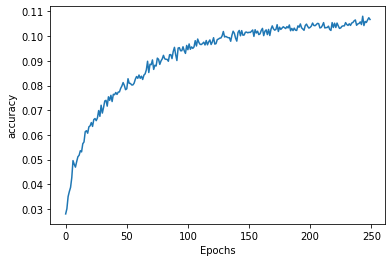

In [10]:
plot_graphs(history, 'accuracy')


In [ ]:
plot_graphs(history, 'loss')

In [ ]:
plot_graphs(history, 'val_loss')

In [ ]:
plot_graphs(history, 'val_accuracy')

In [11]:
def get5TopPredict(predict):
    predicts = predict[0].argsort()[-5:][::-1]
    for i in predicts:
        print(sortedClassContents[i])
        

In [14]:
      
def predictDense(first):
    predict = model.predict([[sortedClassContents.index(first)]])
    get5TopPredict(predict)
    return sortedClassContents[np.argmax(predict[0])]


In [18]:
predictResult = predictDense(1756)
print(predictResult)

700
1833
883
1836
1193
700


In [ ]:
run_model = tf.function(lambda x: model(x))
# This is important, let's fix the input size.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([1,6], model.inputs[0].dtype))

# model directory.
MODEL_DIR = "model"
model.save(MODEL_DIR, save_format="tf", signatures=concrete_func)


In [19]:
MODEL_DIR = "model"
model.save(MODEL_DIR) 

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model/assets


In [20]:
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
tflite_model = converter.convert()

In [23]:
# Run the model with TensorFlow to get expected results.
TEST_CASES = 10

# Run the model with TensorFlow Lite
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)
print(output_details)
print(input_details[0]["index"])
for i in range(TEST_CASES):
  expected = model.predict([[i]])
  interpreter.set_tensor( input_details[0]["index"], np.array([[i]]).astype(np.float32))
  interpreter.invoke()
  result = interpreter.get_tensor(output_details[0]["index"])

  # Assert if the result of TFLite model is consistent with the TF model.
  np.testing.assert_almost_equal(expected, result)
  print("Done. The result of TensorFlow matches the result of TensorFlow Lite.")

  # Please note: TfLite fused Lstm kernel is stateful, so we need to reset
  # the states.
  # Clean up internal states.
  interpreter.reset_all_variables()


[{'name': 'dense_input', 'index': 0, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([-1,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'Identity', 'index': 16, 'shape': array([  1, 151], dtype=int32), 'shape_signature': array([ -1, 151], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
0
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow m

In [22]:
open("tf_model/converted_model.tflite", "wb").write(tflite_model)

3468724

In [24]:
interpreter.set_tensor( input_details[0]["index"], np.array([[sortedClassContents.index(700)]]).astype(np.float32))
interpreter.invoke()
result = interpreter.get_tensor(output_details[0]["index"])
print(sortedClassContents[np.argmax(result)])

1756
